<div style="text-align:center">
    <h1>
        Continuous state spaces
    </h1>
</div>

<br><br>

<div style="text-align:center">
    In this notebook we will learn how to adapt tabular methods to continuous state spaces. We will do it with two methods: 
    state aggregation and tile coding.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 7 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

## Implement state aggregation

<br><br>

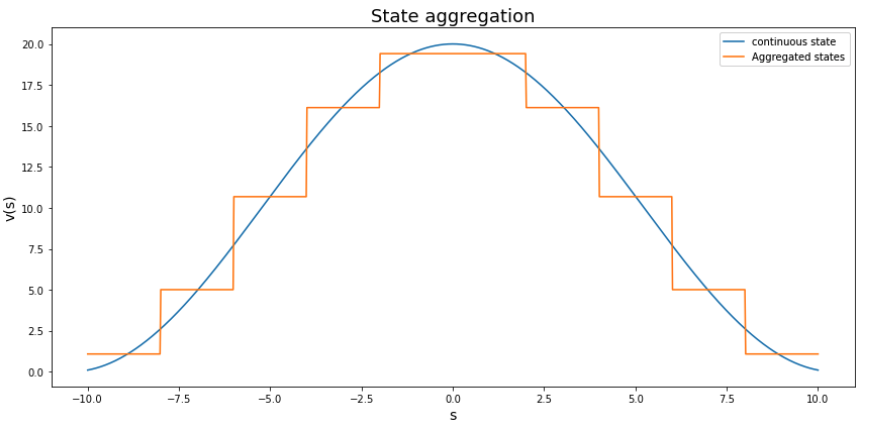

### Create the environment

In [2]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
seed_everything(env) # sets all seeds for determinism

In [3]:
env.reset(seed=42) # seed value taken from seed_everything function

(array([-0.4452088,  0.       ], dtype=float32), {})

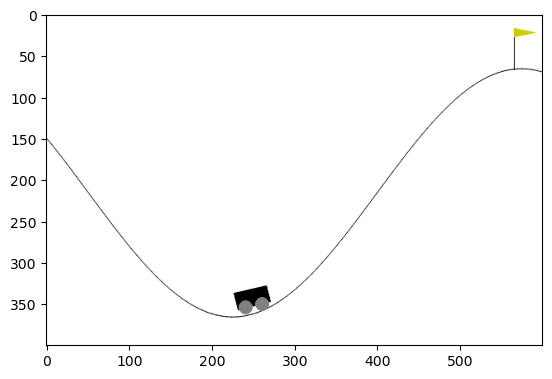

In [4]:
frame = env.render()
plt.imshow(frame)

### Create the state aggregation wrapper

The strategy that we will follow consists in creating an object that will wrap the environment and modify the states that the environment generates. That is every time that we interact with the environment and the environment generates a state, the object that wraps the environment will modify that state so that we can work with it.

In [5]:
class StateAggregationEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high):
        # low = [-1.2, -0.07], high = [0.6, 0.07], bins = [20, 20]
        super().__init__(env)
        
        self.buckets = [np.linspace(l, h, b-1) for l, h, b in zip(low, high, bins)]        
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()) 
        # [20, 20] -> 400 states
        # we will have 20 possible values for the position of the car and
        # 20 possible values for its velocity.
        
    # Here we modify the state that the original environment generates. We go from working with 
    # continuous states to working with aggregated states. 
    def observation(self, state):
        # np.digitize will take as input the continuous value and the buckets where that number can fall.
        indices = tuple(np.digitize(cont, buck) for cont, buck in zip(state, self.buckets))
        return indices        

In [6]:
bins = np.array([20,20]) # Array with the number of discrete states that we want for each dimension of the state
low = env.observation_space.low
high = env.observation_space.high

sa_env =StateAggregationEnv(env, bins, low, high)

In [7]:
sa_env.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Compare the original environment to the one with aggregated states

In [8]:
print(f"Modified observation space: {sa_env.observation_space}, \n\
Sample state: {sa_env.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [ 2 16]


In [9]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [ 0.1931209  -0.00855702]


### Create the $Q(s,a)$ value table

In [10]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [11]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [12]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state, info = sa_env.reset(seed=42)
        action = policy(state, epsilon)
        done_ter, done_trun = False, False
        ep_return = 0
        while not (done_ter or done_trun):
            next_state, reward, done_ter, done_trun, _ = sa_env.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [13]:
stats = sarsa(action_values, policy, 20000, alpha=0.2, epsilon=0.)

100%|████████████████████████████████████| 20000/20000 [02:47<00:00, 119.69it/s]


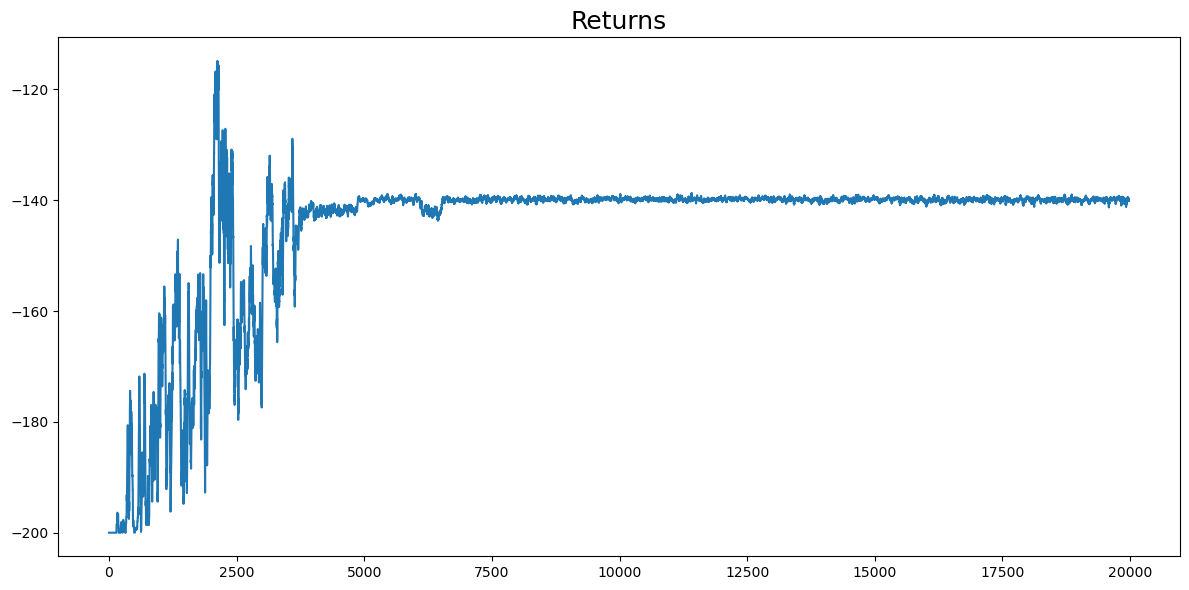

In [14]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

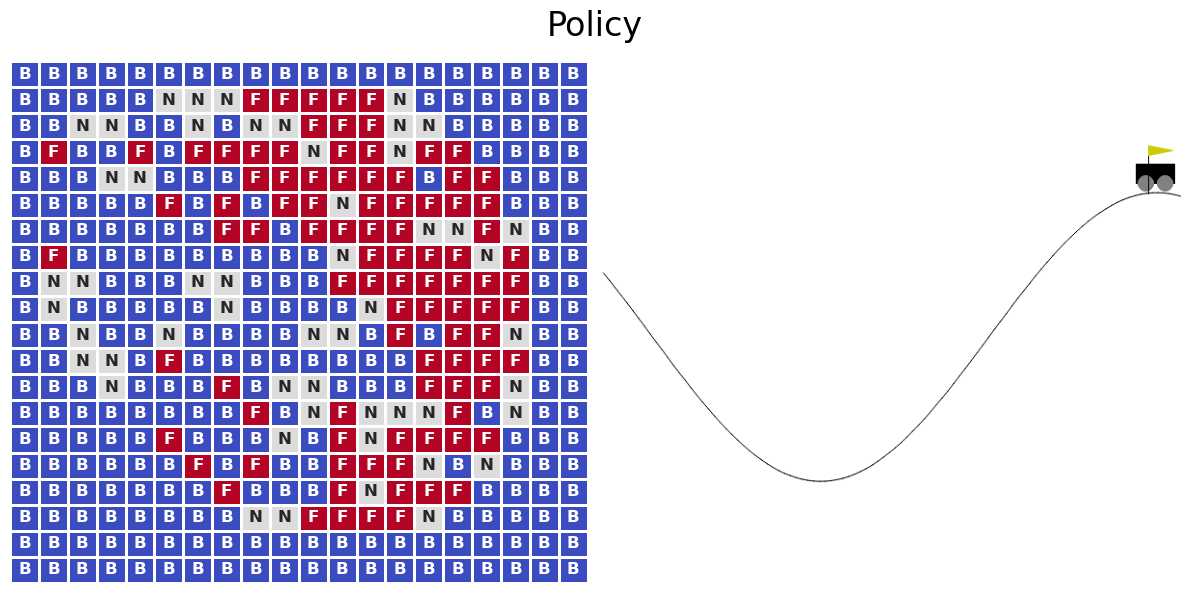

In [15]:
plot_policy(action_values, env.render(), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

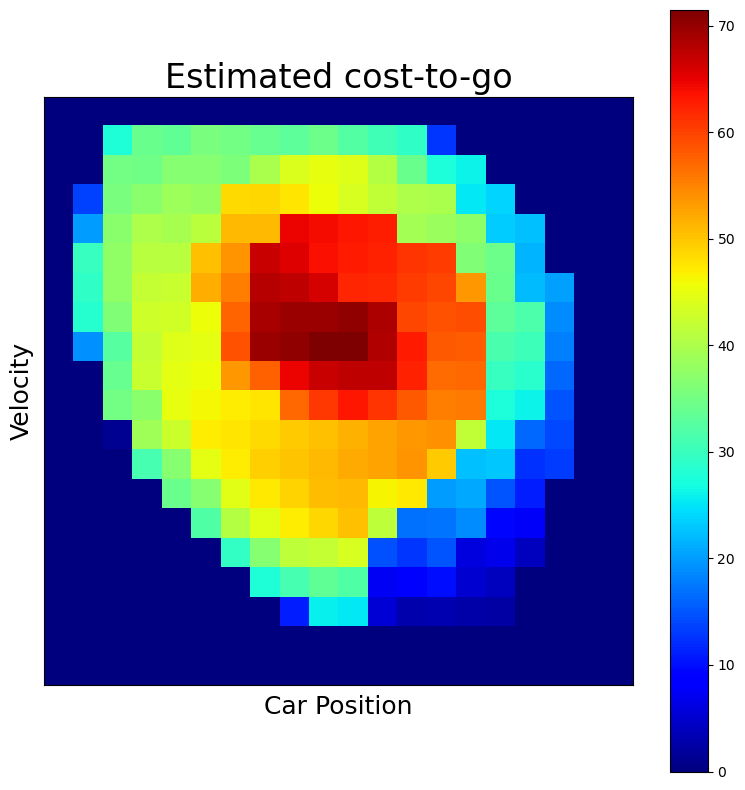

In [16]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [17]:
import utils
test_agent(sa_env, policy, 2)

TypeError: render() got an unexpected keyword argument 'mode'

<Figure size 800x800 with 0 Axes>

<br><br><br><br>

## Implement Tile Coding

<br><br>

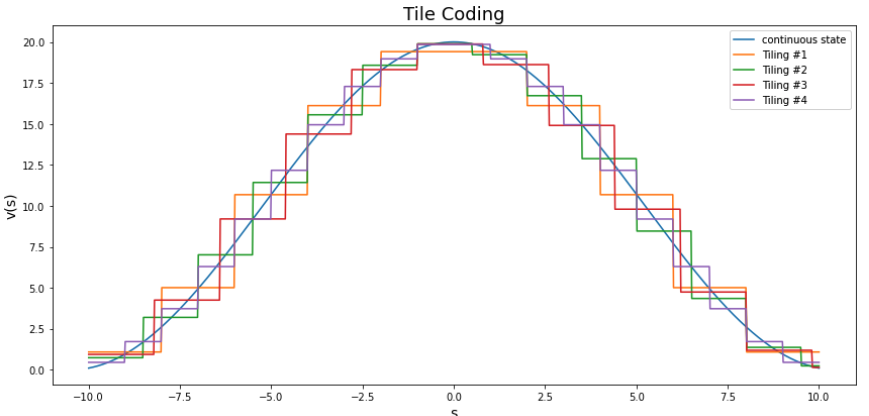

### Create the environment

In [18]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
seed_everything(env) # sets all seeds for determinism

### Create the Tile Coding wrapper

In [19]:
class TileCodingEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high, n):
        # initialize the class
        super().__init__(env)
        
        self.tilings = self._create_tilings(bins, high, low , n)    
        # now the state space will reflect the number of dimensions of the state with n state aggregations
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * n) 

    def observation(self, state):
        # we have n tilings so n tuples of indices
        indices = []
        
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(state, t))
            indices.append(tiling_indices)
        return indices    
    
    # Create tilings
    def _create_tilings(self, bins, high, low , n):
        tilings = []
        # [1, 3]
        displacement_vector = np.arange(1, 2*len(bins), 2) # odd numbers starting from 1 to 2*2
        for i in range(1, n+1):
            low_i = low - random.random() * 0.2 * low # take one of the dim of the state and subtract a certain percentage from it
            high_i = high - random.random() * 0.2 * high # move only by 0.2, ie 20%
            segment_sizes = (high_i - low_i)/bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes/n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(l, h, b-1) for l, h, b in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        return tilings

In [20]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high

tcenv =TileCodingEnv(env, bins, low, high, tilings)

### Compare the original environment to the one with aggregated states

In [21]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: ([(6, 9), (6, 8), (7, 10), (6, 9)], {})


In [22]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: (array([-0.40151632,  0.        ], dtype=float32), {})


### Create the $Q(s,a)$ value table

In [23]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [24]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
            
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment

In [28]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state, info = tcenv.reset(seed=42)
        action = policy(state, epsilon)
        done_ter, done_trun = False, False
        ep_return = 0
        while not (done_ter or done_trun):
            next_state, reward, done_ter, done_trun, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [29]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|█████████████████████████████████████| 20000/20000 [04:08<00:00, 80.32it/s]


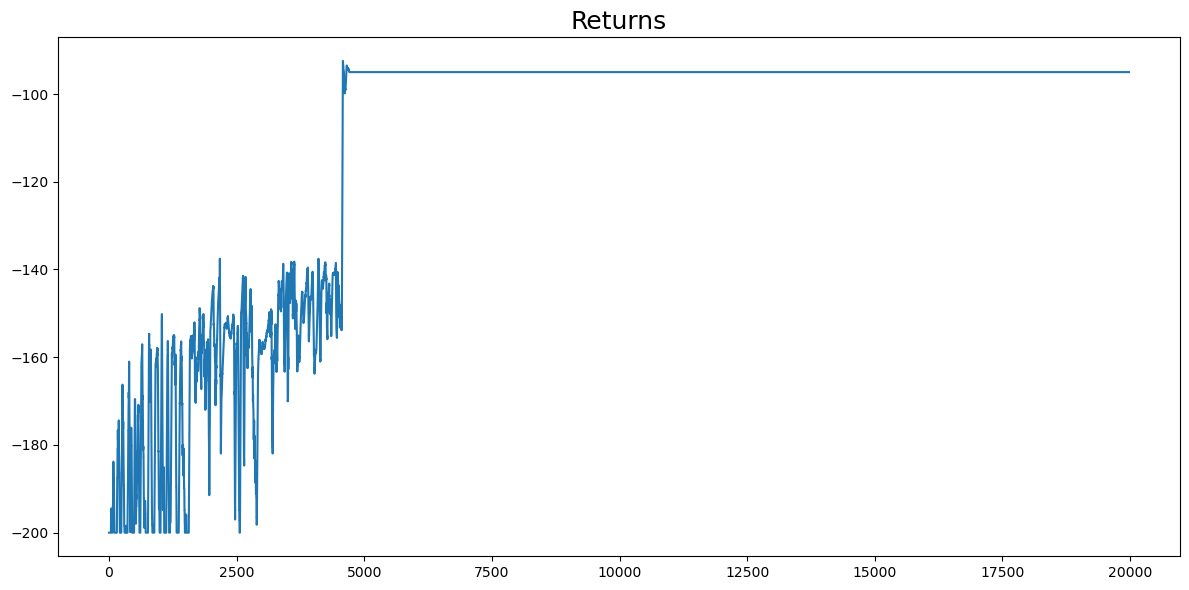

In [30]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

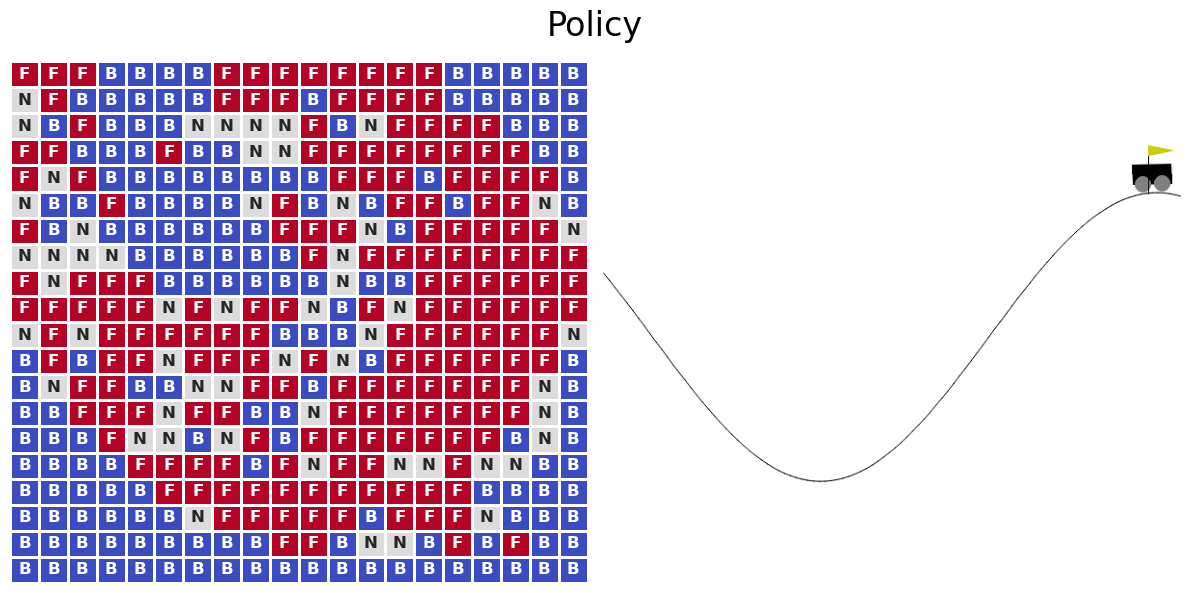

In [31]:
plot_policy(action_values.mean(axis=0), env.render(), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

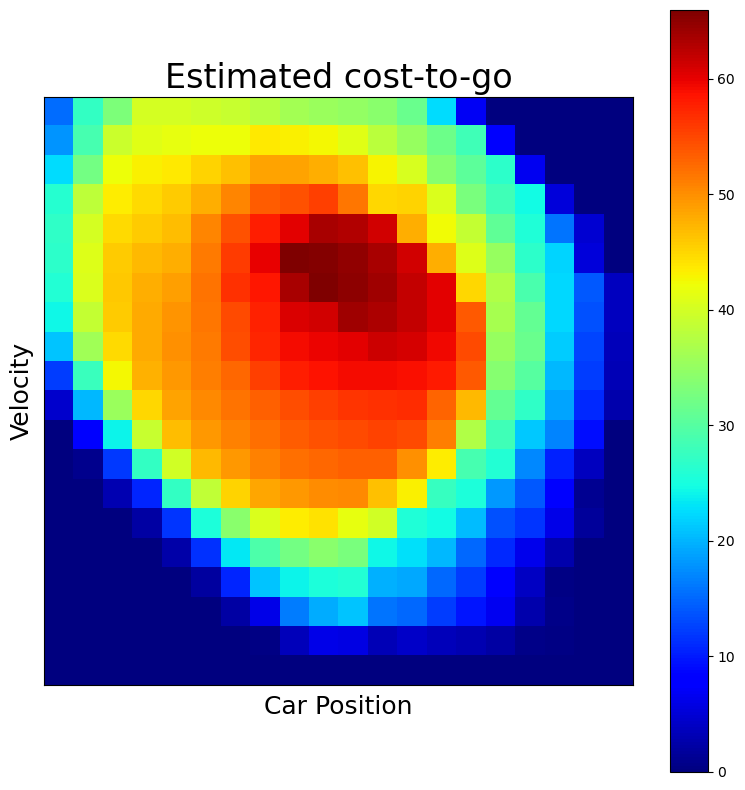

In [32]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [33]:
test_agent(tcenv, policy, 2)

TypeError: render() got an unexpected keyword argument 'mode'

<Figure size 800x800 with 0 Axes>

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)